<a href="https://colab.research.google.com/github/19WH1A0501/Stock-Prediction-Using-LSTM-and-ML-Methods/blob/main/2_final_major_Infosys_CNN_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [ ]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/major datasets /Infosys_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2017-01-02,505.549988,506.475006,499.674988,500.549988,428.489410,2335222,-0.360000,-9,25
1,2017-01-03,502.049988,502.450012,491.000000,496.924988,425.386322,6778482,-0.204545,-9,44
2,2017-01-04,497.524994,502.100006,496.125000,498.875000,427.055542,7073586,-0.333333,-7,21
3,2017-01-05,500.799988,504.750000,494.375000,498.075012,426.370758,8207074,0.166667,1,6
4,2017-01-06,497.450012,499.424988,484.024994,486.125000,416.141113,14393448,-0.205128,-8,39
...,...,...,...,...,...,...,...,...,...,...
1479,2022-12-26,1500.500000,1509.900024,1496.349976,1502.400024,1502.400024,4115459,0.000000,0,28
1480,2022-12-27,1509.949951,1521.449951,1497.500000,1514.849976,1514.849976,4860076,-0.024390,-1,41
1481,2022-12-28,1505.099976,1524.949951,1498.500000,1510.150024,1510.150024,5029860,-0.056604,-3,53
1482,2022-12-29,1504.000000,1521.300049,1501.000000,1517.550049,1517.550049,4624745,0.035714,2,56


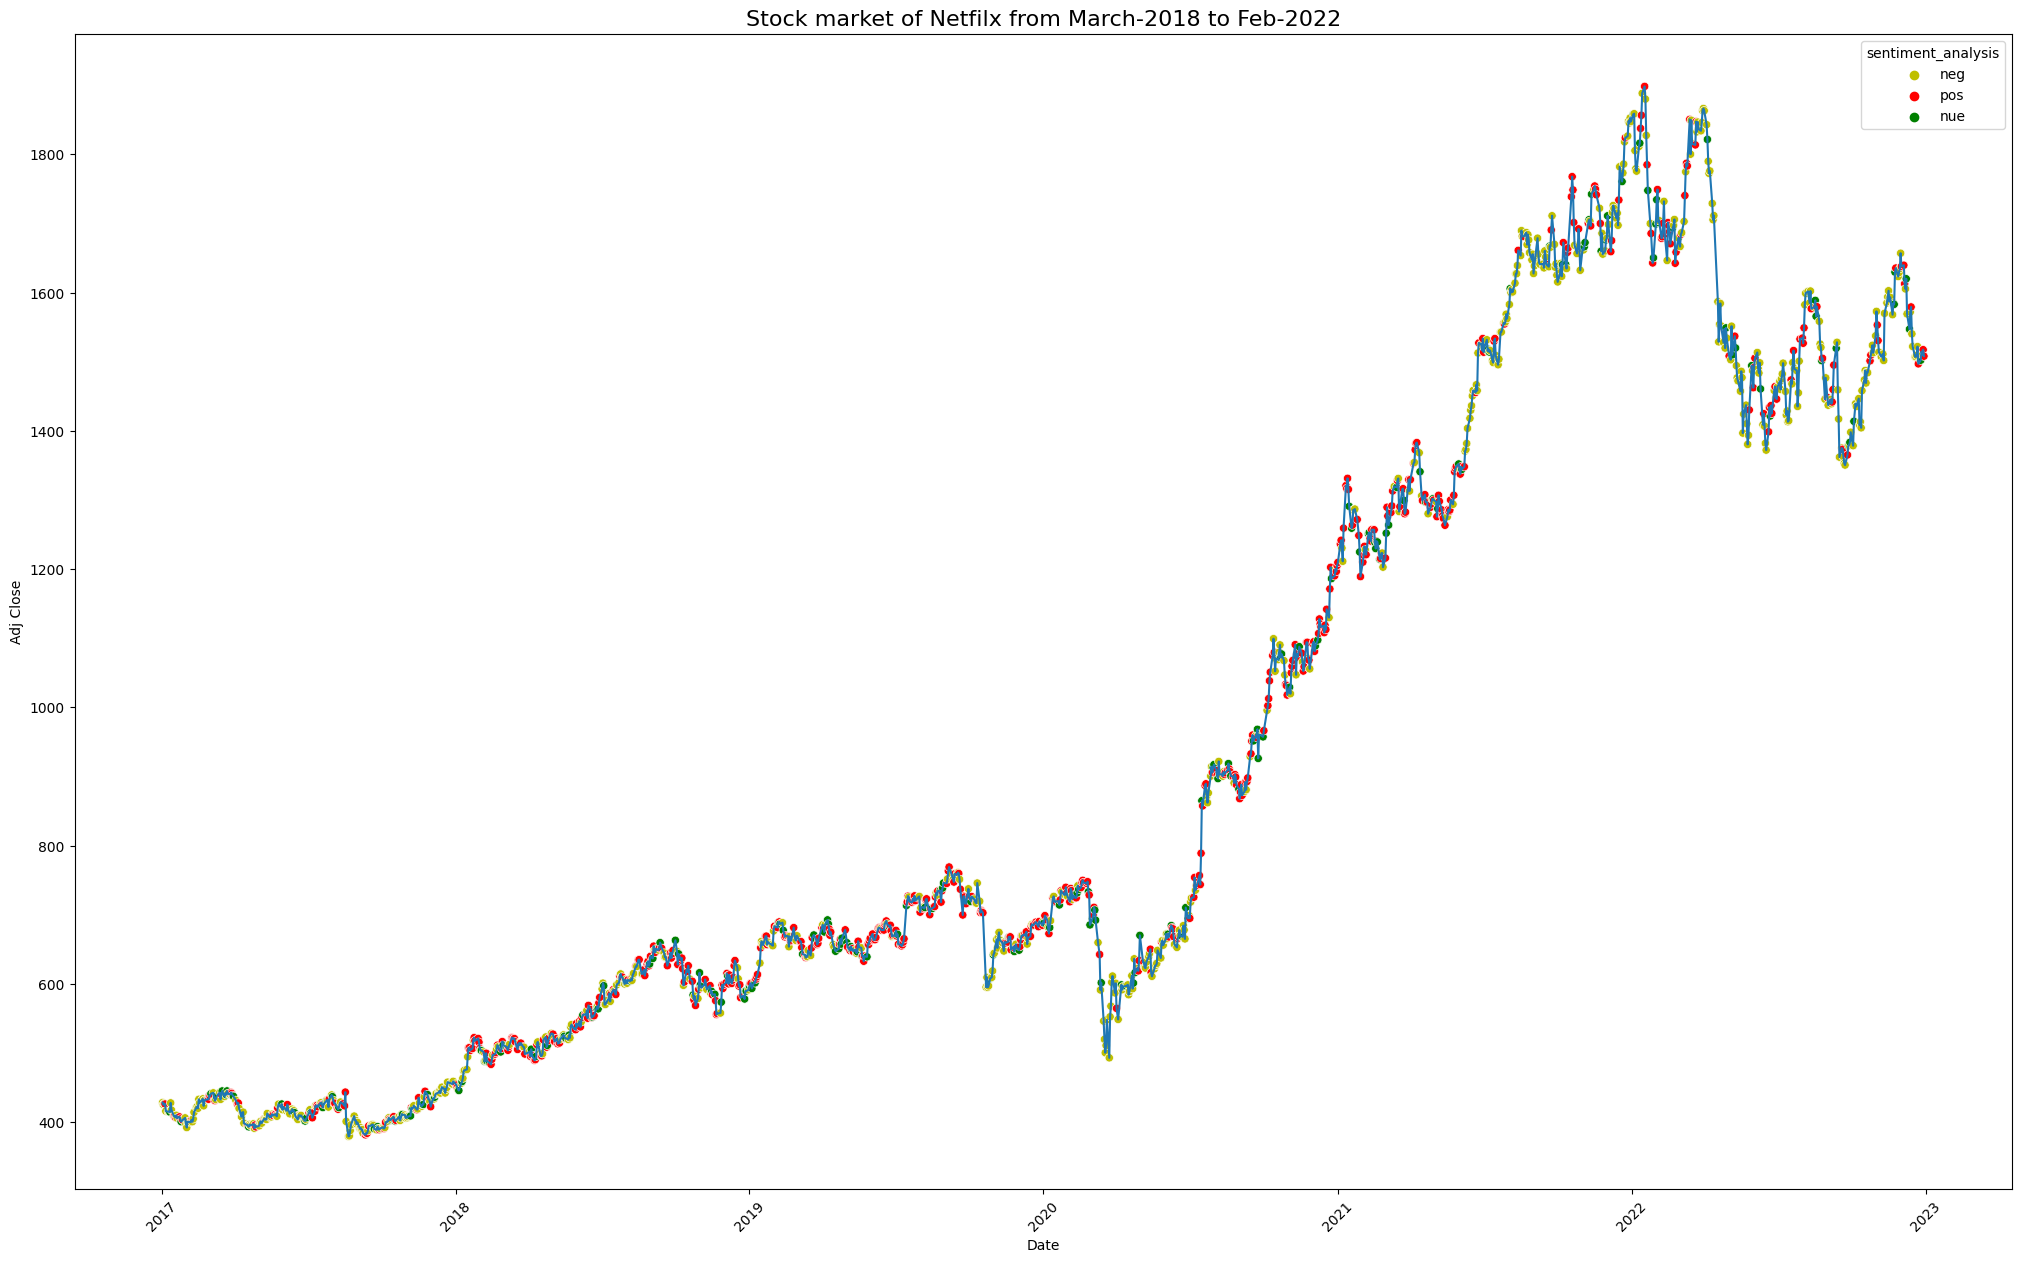

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,15));
sns.lineplot(x=df["Date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["Date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from March-2018 to Feb-2022",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

neg    667
pos    596
nue    221
Name: sentiment_analysis, dtype: int64

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'P_mean',
       'P_sum', 'twt_count', 'sentiment_analysis'],
      dtype='object')

In [ ]:
df['Close'].min()

436.7000122070313

In [ ]:
df['Close'].max()

1939.5

In [ ]:
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
Date,,,,,,,
2017-01-02,505.549988,506.475006,499.674988,500.549988,2335222.0,428.489410,-0.360000
2017-01-03,502.049988,502.450012,491.000000,496.924988,6778482.0,425.386322,-0.204545
2017-01-04,497.524994,502.100006,496.125000,498.875000,7073586.0,427.055542,-0.333333
2017-01-05,500.799988,504.750000,494.375000,498.075012,8207074.0,426.370758,0.166667
2017-01-06,497.450012,499.424988,484.024994,486.125000,14393448.0,416.141113,-0.205128
...,...,...,...,...,...,...,...
2022-12-26,1500.500000,1509.900024,1496.349976,1502.400024,4115459.0,1502.400024,0.000000
2022-12-27,1509.949951,1521.449951,1497.500000,1514.849976,4860076.0,1514.849976,-0.024390
2022-12-28,1505.099976,1524.949951,1498.500000,1510.150024,5029860.0,1510.150024,-0.056604


In [ ]:
_countscaler = MinMaxScaler()
scaler = _countscaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.04374227, 0.04150389, 0.04643451, ..., 0.01129696, 0.03221346,
        0.28651163],
       [0.04140668, 0.0388385 , 0.04065312, ..., 0.03840297, 0.03017043,
        0.38852376],
       [0.0383871 , 0.03860673, 0.04406864, ..., 0.04020325, 0.03126942,
        0.30401079],
       ...,
       [0.71075369, 0.71594592, 0.71209597, ..., 0.02773554, 0.74436335,
        0.48560581],
       [0.71001966, 0.71352893, 0.71376208, ..., 0.02526415, 0.74923542,
        0.54618662],
       [0.72603514, 0.719555  , 0.71579477, ..., 0.02792273, 0.74307945,
        0.53701587]])

In [ ]:
df_for_training_scaled[0]

array([0.04374227, 0.04150389, 0.04643451, 0.04248734, 0.01129696,
       0.03221346, 0.28651163])

In [ ]:
trainX = []
trainY = []

n_future = 1  
n_past = 5  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1479, 5, 7).
TrainY shape = (1479, 1, 2).


In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((1183, 5, 6), (1183, 5, 7))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)
X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)
X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((1064, 5, 6), (1064, 5, 7))

##CNN LSTM Model

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [ ]:
# fit the model

cnn_lstm_model_without_twitter = build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter = build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

In [ ]:
history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=150, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )

Epoch 1/150
17/17 [==============================] - 26s 223ms/step - loss: 0.0193 - val_loss: 0.0049
Epoch 2/150
17/17 [==============================] - 1s 56ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/150
17/17 [==============================] - 1s 58ms/step - loss: 5.4352e-04 - val_loss: 0.0014
Epoch 4/150
17/17 [==============================] - 1s 56ms/step - loss: 4.0680e-04 - val_loss: 6.6136e-04
Epoch 5/150
17/17 [==============================] - 1s 57ms/step - loss: 3.0810e-04 - val_loss: 4.9449e-04
Epoch 6/150
17/17 [==============================] - 1s 58ms/step - loss: 3.1886e-04 - val_loss: 6.4811e-04
Epoch 7/150
17/17 [==============================] - 1s 61ms/step - loss: 2.8205e-04 - val_loss: 5.9109e-04
Epoch 8/150
17/17 [==============================] - 1s 56ms/step - loss: 2.9540e-04 - val_loss: 3.6081e-04
Epoch 9/150
17/17 [==============================] - 1s 56ms/step - loss: 2.6198e-04 - val_loss: 3.2779e-04
Epoch 10/150
17/17 [==========================

In [ ]:
history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=150, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )


Epoch 1/150
17/17 [==============================] - 12s 162ms/step - loss: 0.0348 - val_loss: 0.0192
Epoch 2/150
17/17 [==============================] - 1s 59ms/step - loss: 0.0027 - val_loss: 0.0114
Epoch 3/150
17/17 [==============================] - 1s 58ms/step - loss: 6.8083e-04 - val_loss: 4.8067e-04
Epoch 4/150
17/17 [==============================] - 1s 78ms/step - loss: 4.4571e-04 - val_loss: 5.8553e-04
Epoch 5/150
17/17 [==============================] - 2s 96ms/step - loss: 3.9045e-04 - val_loss: 3.7678e-04
Epoch 6/150
17/17 [==============================] - 2s 96ms/step - loss: 3.0760e-04 - val_loss: 6.7801e-04
Epoch 7/150
17/17 [==============================] - 1s 66ms/step - loss: 3.0519e-04 - val_loss: 3.1982e-04
Epoch 8/150
17/17 [==============================] - 1s 58ms/step - loss: 3.3176e-04 - val_loss: 0.0011
Epoch 9/150
17/17 [==============================] - 1s 61ms/step - loss: 3.0840e-04 - val_loss: 9.9446e-04
Epoch 10/150
17/17 [==========================

In [ ]:
cnn_lstm_model_without_twitter.evaluate(X_test_lstm_without_twitter, y_test_lstm_without_twitter)

10/10 [==============================] - 0s 9ms/step - loss: 5.1522e-04


0.0005152186495251954

In [ ]:
cnn_lstm_model_twitter.evaluate(X_test_lstm_twitter, y_test_lstm_twitter)

10/10 [==============================] - 0s 9ms/step - loss: 6.4748e-04


0.0006474768742918968

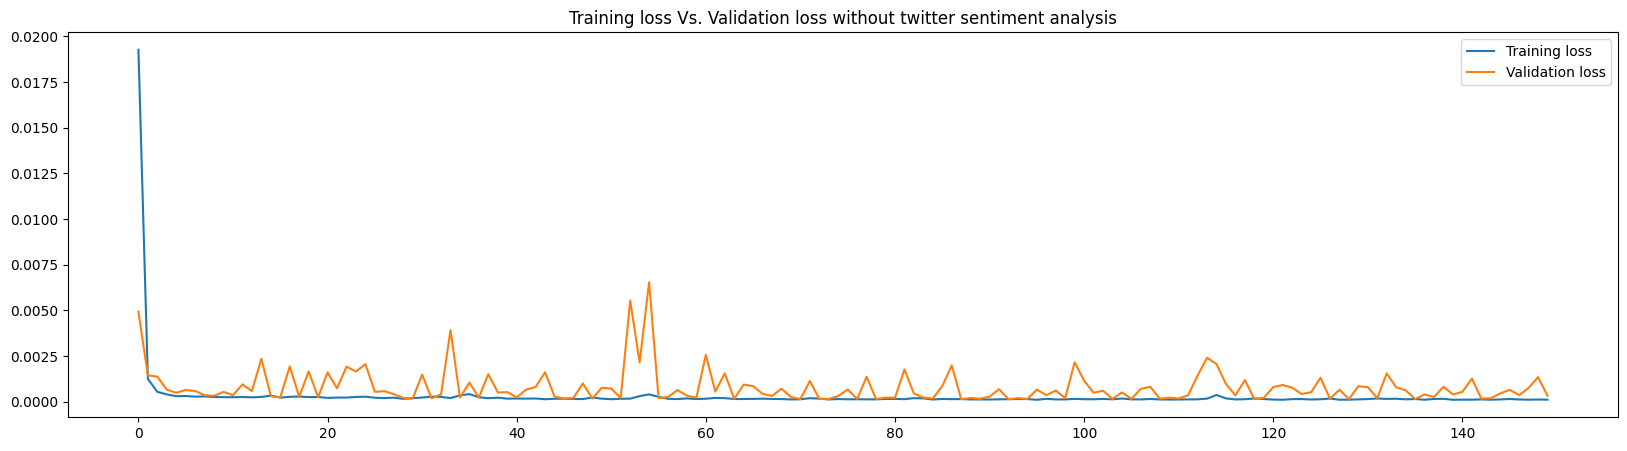

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

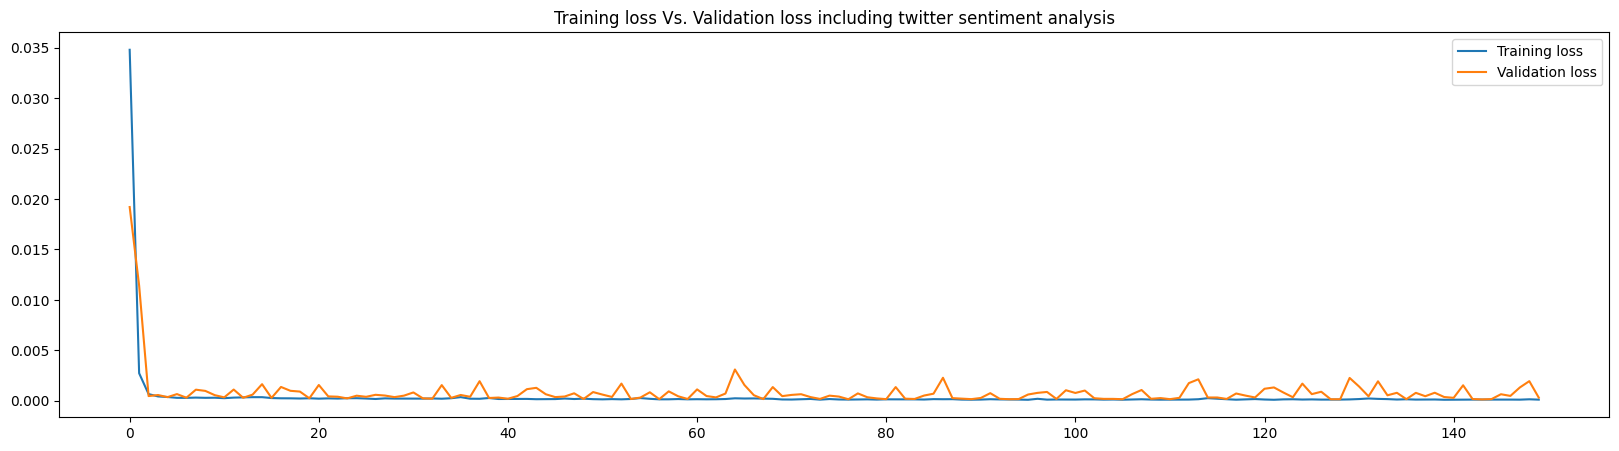

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
from sklearn.metrics import accuracy_score
a = 0
c = 0
def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(10,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()

        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        # print(f'Mean square error for {predicted_feature} ={error}')
    mse = mean_squared_error(y_actual_lstm, y_pred_lstm)
    # print('Total mean square error', mse)
    print("RMSE :", sqrt(mse))
    # print('Accuracy', ((acc)/c)*100)

In [ ]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)
training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)
training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])
training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])
y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)
y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)
y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])
y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

34/34 [==============================] - 2s 9ms/step


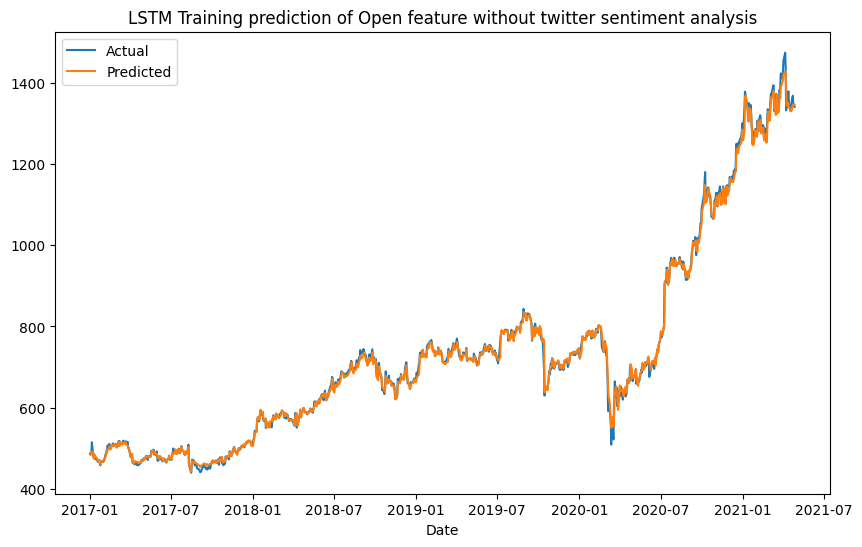

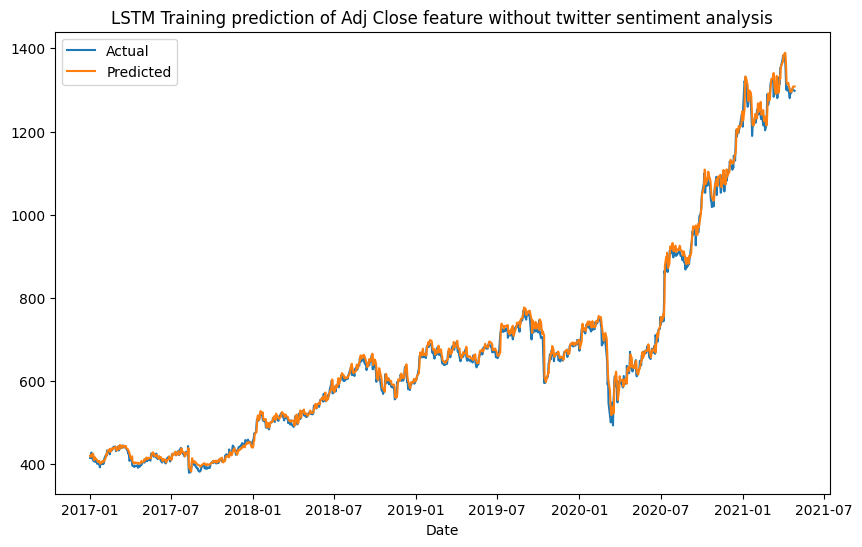

RMSE : 12.565594720013436


In [ ]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

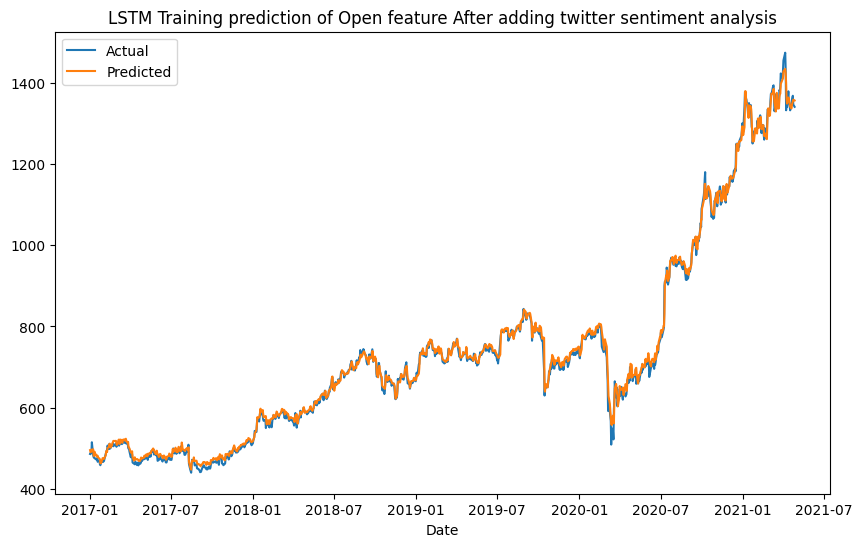

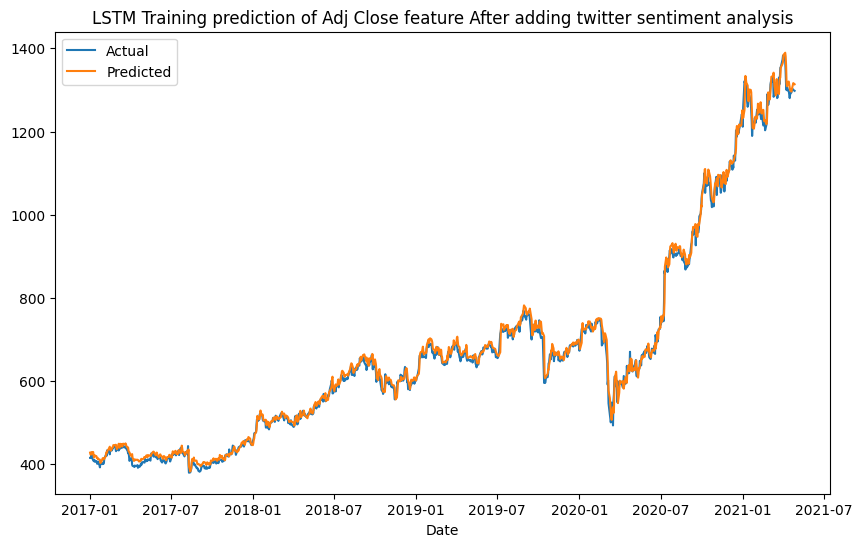

RMSE : 13.166477756136018


In [ ]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

In [ ]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

10/10 [==============================] - 0s 14ms/step


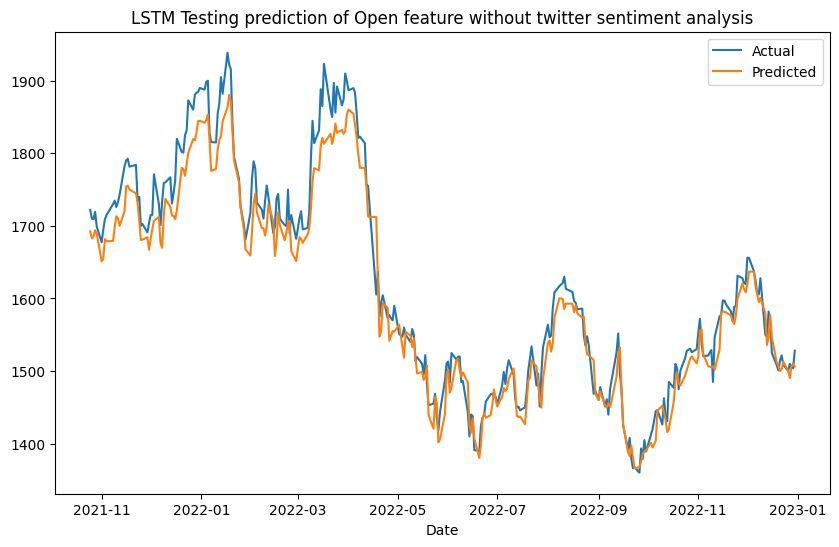

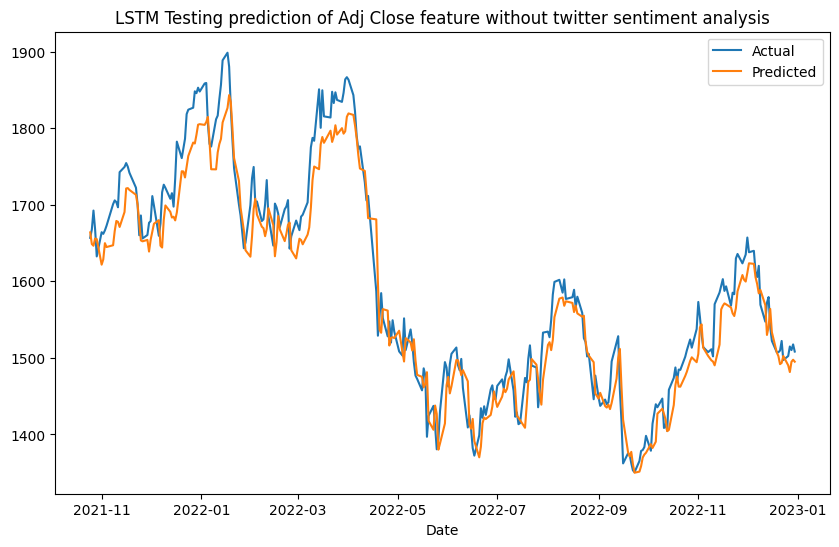

RMSE : 34.26687952228422


In [ ]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

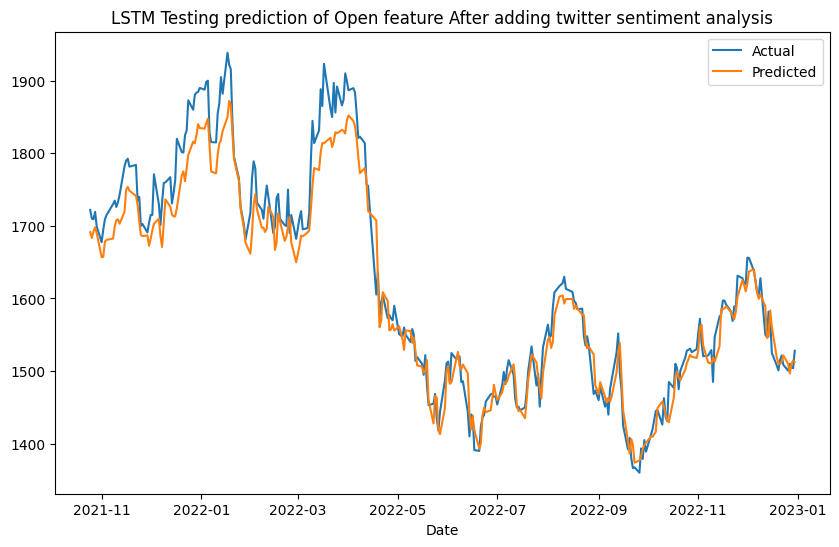

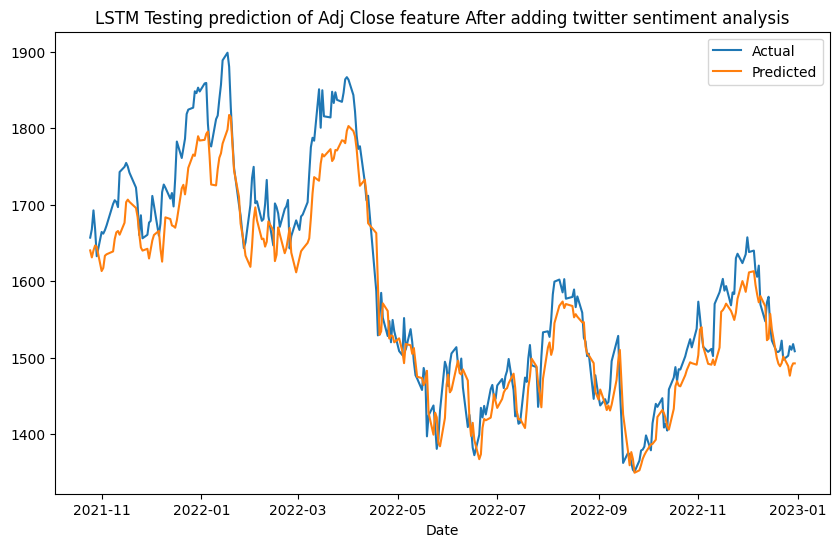

RMSE : 38.45808328327813


In [ ]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

##Data

In [ ]:
data = pd.DataFrame(df_for_training, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean'])
# data['Date'] = df['Date']

In [ ]:
data

,Open,High,Low,Close,Volume,Adj Close,P_mean
Date,,,,,,,
2017-01-02,505.549988,506.475006,499.674988,500.549988,2335222.0,428.489410,-0.360000
2017-01-03,502.049988,502.450012,491.000000,496.924988,6778482.0,425.386322,-0.204545
2017-01-04,497.524994,502.100006,496.125000,498.875000,7073586.0,427.055542,-0.333333
2017-01-05,500.799988,504.750000,494.375000,498.075012,8207074.0,426.370758,0.166667
2017-01-06,497.450012,499.424988,484.024994,486.125000,14393448.0,416.141113,-0.205128
...,...,...,...,...,...,...,...
2022-12-26,1500.500000,1509.900024,1496.349976,1502.400024,4115459.0,1502.400024,0.000000
2022-12-27,1509.949951,1521.449951,1497.500000,1514.849976,4860076.0,1514.849976,-0.024390
2022-12-28,1505.099976,1524.949951,1498.500000,1510.150024,5029860.0,1510.150024,-0.056604


In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [ ]:
RF_model1 = RandomForestClassifier()
RF_model2 = RandomForestClassifier()

In [ ]:
train_X_without_twitter = train_X_without_twitter.astype(int)
train_X_with_twitter = train_X_with_twitter.astype(int)
train_y_without_twitter = train_y_without_twitter.astype(int)
train_y_with_twitter = train_y_with_twitter.astype(int)

test_X_without_twitter = test_X_without_twitter.astype(int)
test_y_without_twitter = test_y_without_twitter.astype(int)
test_X_with_twitter = test_X_with_twitter.astype(int)
test_y_with_twitter = test_y_with_twitter.astype(int)

In [ ]:
RF_model1.fit(train_X_without_twitter, train_y_without_twitter)
RF_model2.fit(train_X_with_twitter, train_y_with_twitter)

RandomForestClassifier()

In [ ]:
prediction1 = RF_model1.predict(test_X_without_twitter)
prediction2 = RF_model2.predict(test_X_with_twitter)

RMSE value for Random Forest Model :  32.90927228031945


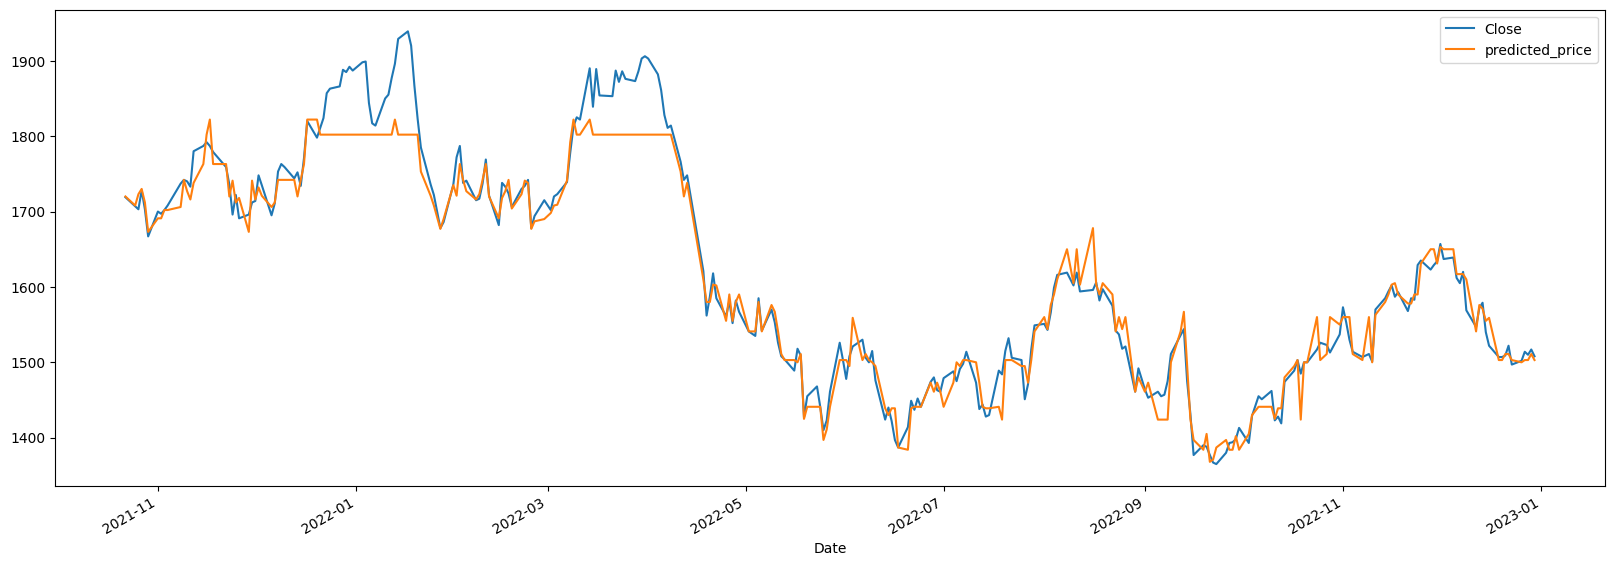

In [ ]:
predictions_df1 = pd.DataFrame(test_y_without_twitter)
predictions_df1['predicted_price'] = prediction1[0:]

predictions_df1.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_without_twitter, prediction1.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

RMSE value for Random Forest Model :  39.028954114340024


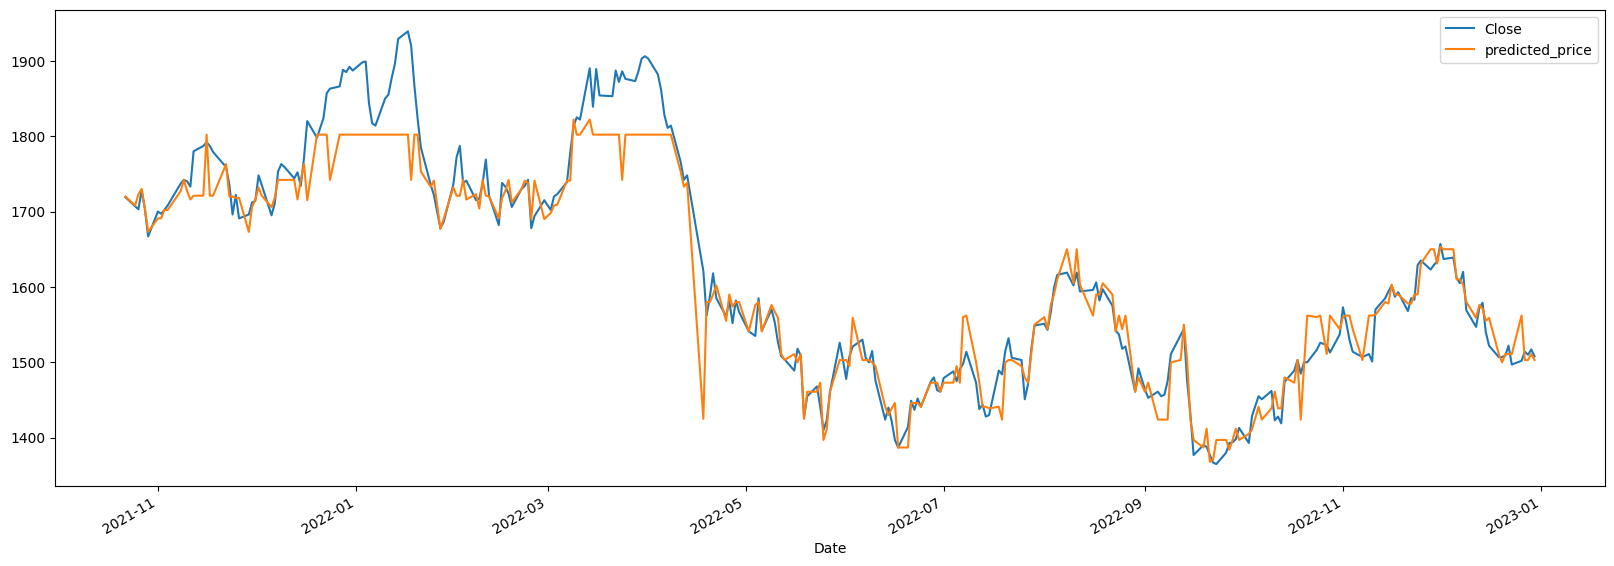

In [ ]:
predictions_df2 = pd.DataFrame(test_y_with_twitter)
predictions_df2['predicted_price'] = prediction2[0:]

predictions_df2.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_with_twitter, prediction2.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

##XG Boost

In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
xgb_r1 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
xgb_r2 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r1.fit(train_X_without_twitter, train_y_without_twitter.values.flatten())
xgb_r2.fit(train_X_with_twitter, train_y_with_twitter.values.flatten())
  
# Predict the model
pred1 = xgb_r1.predict(test_X_without_twitter)
pred2 = xgb_r2.predict(test_X_with_twitter)
  
# RMSE Computation
rmse1 = np.sqrt(MSE(test_y_without_twitter, pred1))
rmse2 = np.sqrt(MSE(test_y_with_twitter, pred2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))

[08:52:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE without twitter :  89.332867
RMSE with twitter:  89.332867


##Support Vector Machine

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.04374227, 0.04150389, 0.04643451, ..., 0.01129696, 0.03221346,
        0.28651163],
       [0.04140668, 0.0388385 , 0.04065312, ..., 0.03840297, 0.03017043,
        0.38852376],
       [0.0383871 , 0.03860673, 0.04406864, ..., 0.04020325, 0.03126942,
        0.30401079],
       ...,
       [0.71075369, 0.71594592, 0.71209597, ..., 0.02773554, 0.74436335,
        0.48560581],
       [0.71001966, 0.71352893, 0.71376208, ..., 0.02526415, 0.74923542,
        0.54618662],
       [0.72603514, 0.719555  , 0.71579477, ..., 0.02792273, 0.74307945,
        0.53701587]])

In [ ]:
data1 = pd.DataFrame(df_for_training_scaled, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean'])

In [ ]:
data1

,Open,High,Low,Close,Volume,Adj Close,P_mean
0,0.043742,0.041504,0.046435,0.042487,0.011297,0.032213,0.286512
1,0.041407,0.038839,0.040653,0.040075,0.038403,0.030170,0.388524
2,0.038387,0.038607,0.044069,0.041373,0.040203,0.031269,0.304011
3,0.040573,0.040362,0.042902,0.040840,0.047118,0.030819,0.632120
4,0.038337,0.036835,0.036005,0.032889,0.084858,0.024084,0.388141
...,...,...,...,...,...,...,...
1479,0.707684,0.705980,0.710663,0.709143,0.022157,0.739261,0.522750
1480,0.713990,0.713628,0.711430,0.717427,0.026700,0.747458,0.506745
1481,0.710754,0.715946,0.712096,0.714300,0.027736,0.744363,0.485606
1482,0.710020,0.713529,0.713762,0.719224,0.025264,0.749235,0.546187


In [ ]:
train, test = train_test_split(data1, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

In [ ]:
df_for_training['Close'].min()

436.7000122070313

In [ ]:
df_for_training['Close'].max()

1939.5

In [ ]:
from sklearn import svm
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
svr_rbf1 = SVR(kernel='rbf', C=1, gamma=0.0001)
svr_rbf2 = SVR(kernel='rbf', C=1, gamma=0.0001)

svr_rbf1.fit(train_X_without_twitter.values, train_y_without_twitter.values)
svr_rbf2.fit(train_X_with_twitter.values, train_y_with_twitter.values)

output_test_svm1 = svr_rbf1.predict(test_X_without_twitter)
output_test_svm2 = svr_rbf2.predict(test_X_with_twitter)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [ ]:
actual = pd.DataFrame(test_y_without_twitter)
scaler = MinMaxScaler(feature_range=(436, 1939))
scaler = scaler.fit(actual)
actual1 = scaler.transform(actual)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(actual)

actual1

array([[1363.77310596],
       [1331.69968303],
       [1321.6192087 ],
       [1387.72973352],
       [1322.14304819],
       [1227.49365864],
       [1312.06289348],
       [1306.43361655],
       [1318.47745022],
       [1334.71040174],
       [1410.11580145],
       [1423.20699449],
       [1417.05419768],
       [1399.11932715],
       [1521.91446211],
       [1540.1114122 ],
       [1553.59540494],
       [1540.89669201],
       [1519.82006299],
       [1467.45529086],
       [1408.54492221],
       [1301.45889928],
       [1370.58046241],
       [1290.06962526],
       [1302.37521887],
       [1345.052636  ],
       [1350.94367286],
       [1438.26186648],
       [1405.01036401],
       [1299.6262601 ],
       [1342.43439739],
       [1451.61481945],
       [1478.05896545],
       [1467.06249115],
       [1428.83627141],
       [1448.47306096],
       [1401.47548621],
       [1499.39767402],
       [1628.3459254 ],
       [1570.87571582],
       [1604.12721829],
       [1638.426

In [ ]:
predicted = pd.DataFrame(output_test_svm1)

In [ ]:
scaler = MinMaxScaler(feature_range=(436, 1939))
scaler = scaler.fit(predicted)
predicted1 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted1

array([[1410.11277284],
       [1339.1103189 ],
       [1333.34308867],
       [1343.81515758],
       [1336.64002787],
       [1280.93238519],
       [1270.54910797],
       [1294.36865519],
       [1327.3946477 ],
       [1337.92784503],
       [1369.85934541],
       [1402.15900217],
       [1391.64351363],
       [1376.66056187],
       [1448.64634845],
       [1530.92511279],
       [1546.83623671],
       [1546.37973186],
       [1506.84568889],
       [1498.25922747],
       [1385.51996126],
       [1364.89239784],
       [1325.22760304],
       [1309.29635106],
       [1280.66453728],
       [1333.80952677],
       [1366.13802962],
       [1372.2045245 ],
       [1471.75378326],
       [1353.8148661 ],
       [1322.52249684],
       [1415.10509523],
       [1454.78880644],
       [1454.22853343],
       [1460.55245474],
       [1396.44358522],
       [1405.34676333],
       [1478.83040627],
       [1626.52464284],
       [1584.34552163],
       [1603.05404549],
       [1626.500

In [ ]:
predicted = pd.DataFrame(output_test_svm2)

In [ ]:
scaler = MinMaxScaler(feature_range=(436, 1939))
scaler = scaler.fit(predicted)
predicted2 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted2

array([[1404.35399836],
       [1312.98334599],
       [1324.3013125 ],
       [1348.44129825],
       [1327.57554161],
       [1278.73669569],
       [1281.47912123],
       [1292.18733473],
       [1329.15570153],
       [1339.61633297],
       [1374.41635315],
       [1403.40500025],
       [1386.28998607],
       [1386.42057948],
       [1449.57209141],
       [1528.19534982],
       [1551.59285036],
       [1549.83936182],
       [1514.7822702 ],
       [1495.75449186],
       [1390.21614358],
       [1366.39512904],
       [1318.37577418],
       [1305.22497522],
       [1266.06538709],
       [1335.52638835],
       [1361.67510381],
       [1373.65688172],
       [1464.70156821],
       [1365.01497619],
       [1331.2659417 ],
       [1409.49978506],
       [1452.98208237],
       [1446.48810631],
       [1449.0398335 ],
       [1389.97075019],
       [1404.90291911],
       [1485.67941586],
       [1619.80978085],
       [1584.33641474],
       [1590.08451008],
       [1620.641

In [ ]:
rmse1 = np.sqrt(MSE(actual1, predicted1))
rmse2 = np.sqrt(MSE(actual1, predicted2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))


RMSE without twitter :  35.648097
RMSE with twitter:  36.004078


In [ ]:
#@title Default title text
plt.figure(figsize=(20,7))
plt.plot(test_y_without_twitter.iloc[:].values)
plt.plot(output_test_svm1)
plt.title('SVM predicted prices')
plt.ylabel('Stock Prices')
plt.xlabel('Days')
plt.legend(['actual', 'predicted'])
plt.show()

In [ ]:

rmse = sqrt(mean_squared_error(test_y_without_twitter, output_test_svm1.flatten()))
print("RMSE value for SVM Model : ", rmse)

RMSE value for SVM Model :  0.7226805701537387


In [ ]:
#@title Default title text
plt.figure(figsize=(20,7))
plt.plot(test_y_with_twitter.iloc[:].values)
plt.plot(output_test_svm1)
plt.title('SVM predicted prices')
plt.ylabel('Stock Prices')
plt.xlabel('Days')
plt.legend(['actual', 'predicted'])
plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(test_y_with_twitter, output_test_svm2.flatten()))
print("RMSE value for SVM Model : ", rmse)

RMSE value for SVM Model :  0.7226805701537387


In [ ]:
#@title Default title text
plt.figure(figsize=(20,7))
plt.plot(test_y_with_twitter.iloc[:].values)
plt.plot(pred1)
plt.title('XG Boost predicted prices without Twitter')
plt.ylabel('Stock Prices')
plt.xlabel('Days')
plt.legend(['actual', 'predicted'])
plt.show()

rmse = sqrt(mean_squared_error(test_y_with_twitter, pred1.flatten()))
print("RMSE value for XG Boost Model : ", rmse)

In [ ]:
#@title Default title text
plt.figure(figsize=(20,7))
plt.plot(test_y_with_twitter.iloc[:].values)
plt.plot(pred2)
plt.title('XG Boost predicted prices with Twitter')
plt.ylabel('Stock Prices')
plt.xlabel('Days')
plt.legend(['actual', 'predicted'])
plt.show()

rmse = sqrt(mean_squared_error(test_y_with_twitter, pred2.flatten()))
print("RMSE value for XG Boost Model : ", rmse)
